In [2]:
import csv
import os
import pickle
from collections import Counter
from typing import List, Any, Dict, Tuple, Set, Iterable, Sequence
from operator import itemgetter
from itertools import combinations, starmap, groupby, product, chain, islice, takewhile

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from conversant.conversation import Conversation
from conversant.conversation.parse import DataFrameConversationReader
from conversant.interactions import InteractionsGraph
from conversant.interactions.interactions_graph import PairInteractionsData
from conversant.interactions.reply_interactions_parser import get_reply_interactions_parser
from stance_classification.classifiers.base_stance_classifier import BaseStanceClassifier
from stance_classification.classifiers.greedy_stance_classifier import MSTStanceClassifier
from stance_classification.draw_utils import new_figure
%matplotlib inline

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [3]:
def load_authors_map(authors_root_path: str) -> Dict[str, str]:
    post_authors_map = {}
    for topic_name in os.listdir(authors_root_path):
        topic_dirpath = os.path.join(authors_root_path, topic_name)
        for discussion_file in os.listdir(topic_dirpath):
            discussion_path = os.path.join(topic_dirpath, discussion_file)
            with open(discussion_path, 'r') as f:
                post_author_pairs = list(map(lambda l: tuple(map(str.strip, l.strip().split(' ', 1))), f))
                try:
                    post_full_id_author_pairs = [(f"{topic_name}.{post_id}", author) for post_id, author in post_author_pairs]
                    post_authors_map.update(post_full_id_author_pairs)
                except:
                    print([e for e in post_author_pairs if len(e) != 2])
                    raise

    return post_authors_map

In [4]:
posts_author_path = "/home/dev/data/stance/create-debate/reason/stance/authors"
authors_map = load_authors_map(posts_author_path)
len(authors_map)

4728

In [5]:
def get_author(topic: str, post_id: str) -> str:
    return authors_map.get(post_id, None)

def get_record_from_post(topic_dir: str, meta_file: str) -> Dict[str, Any]:
    topic = topic_dir.split("/")[-1]
    discussion_id = topic + "." + "".join(takewhile(str.isalpha, meta_file))
    meta_filepath = os.path.join(topic_dir, meta_file)
    text_filepath = os.path.join(topic_dir, meta_filepath.split(".")[0] + ".data")
    with open(text_filepath, 'r') as text_f:
        text = text_f.read().strip()

    """ example to meta file content:
        ID=24
        PID=23
        Stance=-1
        rebuttal=oppose
    """
    record = {}
    with open(meta_filepath, 'r') as meta_f:
        post_id = discussion_id + next(meta_f).strip().split("=")[1]
        parent_id_str = next(meta_f).strip().split("=")[1]
        parent_post_id = (discussion_id + parent_id_str) if parent_id_str != "-1" else None
        stance_str = next(meta_f).strip().split("=")[1]
        stance = int(bool(int(stance_str) + 1)) if len(stance_str) > 0 else None
        rebuttal = next(meta_f).strip().split("=")[1]
        author_id = get_author(topic, post_id)
        if parent_post_id == -1:
            parent_post_id = None


        record.update(
            dict(topic=topic, discussion_id=discussion_id, post_id=post_id, author_id=author_id, creation_date=-1,
                      parent_post_id=parent_post_id, text=text, discussion_stance_id=stance, rebuttal=rebuttal)
        )
    return record

In [6]:
data_root_dir = "/home/dev/data/stance/create-debate/reason/stance"
records = []
for topic_dirname in os.listdir(data_root_dir):
    if topic_dirname == "author": continue
    topic_dirpath = os.path.join(data_root_dir, topic_dirname)
    if not os.path.isdir(topic_dirpath): continue
    for post_file in os.listdir(topic_dirpath):
        if post_file.endswith(".meta"):
            record = get_record_from_post(topic_dirpath, post_file)
            records.append(record)

len(records)

4902

In [7]:
df = pd.DataFrame.from_records(records)
df

,topic,discussion_id,post_id,author_id,creation_date,parent_post_id,text,discussion_stance_id,rebuttal
0,abortion,abortion.A,abortion.A1,jstantall,-1,None,There is only one question when it comes to ab...,0.0,null
1,abortion,abortion.A,abortion.A10,NVYN,-1,abortion.A3,People often try to personalize their pro-life...,1.0,oppose
2,abortion,abortion.A,abortion.A100,atypican,-1,abortion.A97,we're saying that the pregnant person should h...,1.0,support
3,abortion,abortion.A,abortion.A101,atypican,-1,abortion.A100,"No answer to my retort, just a down vote. That...",1.0,support
4,abortion,abortion.A,abortion.A102,SMCdeBater,-1,abortion.A101,I'm sooo sick of people like you who feel like...,0.0,oppose
...,...,...,...,...,...,...,...,...,...
4897,obama,obama.O,obama.O5,illini527,-1,None,It's funny how everyone blames the Republicans...,0.0,null
4898,obama,obama.O,obama.O6,1debater,-1,None,"""Yes we can!"" roared the crowd. It was an emot...",0.0,null
4899,obama,obama.O,obama.O7,iamdavidh,-1,obama.O6,1. This is plagiarism. Cite your source next t...,1.0,oppose
4900,obama,obama.O,obama.O8,BlackSheep,-1,None,I think Obama has been a great President. I th...,1.0,null


In [8]:
# unified_data_path = "/home/dev/data/stance/create-debate/reason/stance/all_records.csv"
# df.to_csv(unified_data_path)

#### fill all missing parents as direct replies to the discussion title (with post id as the discussion's

In [9]:
df["parent_post_id"] = df.apply(
    lambda row: (row["discussion_id"] + "0") if row["parent_post_id"] is None else row["parent_post_id"],
    axis=1
)
df["parent_post_id"]

0         abortion.A0
1         abortion.A3
2        abortion.A97
3       abortion.A100
4       abortion.A101
            ...      
4897         obama.O0
4898         obama.O0
4899         obama.O6
4900         obama.O0
4901         obama.O0
Name: parent_post_id, Length: 4902, dtype: object

#### add the first post to the dataframe
add the record that started the discussion as posts in the discussion, so the conversation parser would add them as records.


In [10]:
new_records = []
for discussion_id in df["discussion_id"].unique():
    topic = discussion_id.split(".")[0]
    record = {
        "topic": topic,
        "discussion_id": discussion_id,
        "post_id": discussion_id + "0",
        "author_id": "!UNK",
        "creation_date": "00:00",
        "parent_post_id": None,
        "text": "",
        "discussion_stance_id": 0.5,
        "rebuttal": None
    }
    new_records.append(record)

In [11]:
df = df.append(new_records, ignore_index=True)
df

,topic,discussion_id,post_id,author_id,creation_date,parent_post_id,text,discussion_stance_id,rebuttal
0,abortion,abortion.A,abortion.A1,jstantall,-1,abortion.A0,There is only one question when it comes to ab...,0.0,null
1,abortion,abortion.A,abortion.A10,NVYN,-1,abortion.A3,People often try to personalize their pro-life...,1.0,oppose
2,abortion,abortion.A,abortion.A100,atypican,-1,abortion.A97,we're saying that the pregnant person should h...,1.0,support
3,abortion,abortion.A,abortion.A101,atypican,-1,abortion.A100,"No answer to my retort, just a down vote. That...",1.0,support
4,abortion,abortion.A,abortion.A102,SMCdeBater,-1,abortion.A101,I'm sooo sick of people like you who feel like...,0.0,oppose
...,...,...,...,...,...,...,...,...,...
4963,obama,obama.K,obama.K0,!UNK,00:00,None,,0.5,None
4964,obama,obama.L,obama.L0,!UNK,00:00,None,,0.5,None
4965,obama,obama.M,obama.M0,!UNK,00:00,None,,0.5,None
4966,obama,obama.N,obama.N0,!UNK,00:00,None,,0.5,None


In [12]:
pasre_strategy = {
    "node_id": "post_id",
    "author": "author_id",
    "timestamp": "creation_date",
    "parent_id": "parent_post_id"
    }
parser = DataFrameConversationReader(pasre_strategy)
gb = df.groupby("discussion_id")
convs: List[Conversation] = list(tqdm(map(parser.parse, map(itemgetter(1), gb))))
len(convs)

66

In [13]:
sub_convs = [Conversation(child) for conv in convs for child in conv.root.children]
len(sub_convs)

1456

#conversation stats

In [14]:
sizes = [c.size for c in sub_convs]
print(len(sizes))
print(np.mean(sizes))
print(np.median(sizes))
pd.Series(sizes).describe()

1456
3.2493131868131866
1.0


count    1456.000000
mean        3.249313
std         6.341079
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        80.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

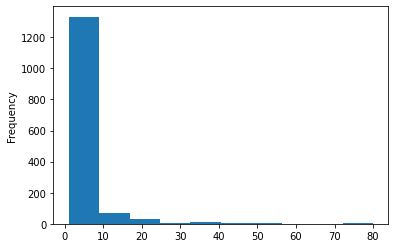

In [15]:
pd.Series(sizes).plot.hist()

In [16]:
filtered_sizes = [s for s in sizes if s >= 10]
print(len(filtered_sizes))
print(np.mean(filtered_sizes))
print(np.median(filtered_sizes))

112
20.758928571428573
16.0


In [17]:
post_labels = {(conv.id, node.node_id): node.data["discussion_stance_id"] for conv in sub_convs for _,node in conv.iter_conversation() if node.data["discussion_stance_id"] != 0.5}
len(post_labels)


4731

## Load Author labels

In [19]:
def get_majority_vote(labels: List[int]) -> int:
    return int(np.mean(labels) >= 0.5)

def get_author_labels(c: Conversation) -> Dict[Any, int]:
    authors_post_labels = {}
    for depth, node in c.iter_conversation():
        data = node.data
        author = node.author
        current_author_labels = authors_post_labels.setdefault(author, [])
        current_author_labels.append(data["discussion_stance_id"])

    result_labels = {a: get_majority_vote(labels) for a, labels in authors_post_labels.items()}
    return result_labels

author_labels_per_conversation = {c.id: get_author_labels(c) for c in sub_convs}
author_labels_per_conversation = {k: v for k, v in author_labels_per_conversation.items() if len(v) > 0 and not (len(v) == 1 and None in v)}
print(len(author_labels_per_conversation))
print(sum(len(v) for v in author_labels_per_conversation.values()))

1398
2717


In [21]:
def get_ordered_candidates_for_pivot(graph: nx.Graph, weight_field: str = "weight") -> Sequence[Any]:
    inv_weight_field = "inv_weight"
    for _, _, pair_data in graph.edges(data=True):
        weight = pair_data.data[weight_field]
        pair_data.data[inv_weight_field] = 1 / weight

    node_centralities = nx.closeness_centrality(graph, distance=inv_weight_field)
    return list(map(itemgetter(0), sorted(node_centralities.items(), key=itemgetter(1), reverse=True)))

def get_pivot_node(graph: nx.Graph, labeled_authors: Set[Any], weight_field: str = "weight") -> Any:
    candidates = get_ordered_candidates_for_pivot(graph, weight_field=weight_field)
    return next(iter(filter(labeled_authors.__contains__, candidates)), None)

In [22]:
def extend_preds(graph: nx.Graph, seed_node: Any, core_authors_preds: Dict[Any, int]) -> Dict[Any, int]:
    extended_results = dict(core_authors_preds.items())
    for (n1, n2) in nx.bfs_edges(graph, source=seed_node):
        if n2 not in extended_results:
            n1_label = extended_results[n1]
            extended_results[n2] = 1 - n1_label

    return extended_results

def get_authors_labels_in_conv(conv: Conversation) -> Dict[Any, int]:
    if conv.id not in author_labels_per_conversation:
        return None

    return author_labels_per_conversation[conv.id]

def get_author_preds(clf: BaseStanceClassifier, pivot: Any) -> Dict[Any, int]:
    support_label = authors_labels[pivot]
    opposer_label = 1 - support_label
    supporters = clf.get_supporters()
    opposers = clf.get_complement()
    preds = {}
    for supporter in supporters:
        preds[supporter] = support_label
    for opposer in opposers:
        preds[opposer] = opposer_label

    return preds

def get_maxcut_results(graph: InteractionsGraph, op: Any) -> MaxcutStanceClassifier:
    maxcut = MaxcutStanceClassifier(weight_field=graph.WEIGHT_FIELD)
    maxcut.set_input(graph.graph, op)
    maxcut.classify_stance()
    return maxcut

def get_greedy_results(graph: InteractionsGraph, op: Any) -> BaseStanceClassifier:
    clf = MSTStanceClassifier()#weight_field=graph.WEIGHT_FIELD)
    clf.set_input(graph.graph)
    clf.classify_stance(op)
    return clf

def align_gs_with_predictions(authors_labels: Dict[Any, int], author_preds: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    for author, true_label in authors_labels.items():
        pred = author_preds.get(author, None)
        if pred is None: continue

        y_true.append(true_label)
        y_pred.append(pred)

    return y_true, y_pred

def predict_for_partition(true: List[int], preds: List[int]) -> Tuple[List[int], List[int]]:
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        preds = [1-l for l in preds]

    return true, preds

def get_best_preds(true_labels: Dict[Any, int], pred_labels: Dict[Any, int]) -> Dict[Any, int]:
    true, preds = align_gs_with_predictions(true_labels, pred_labels)
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        return {k: (1-  l) for k, l in pred_labels.items()}

    return pred_labels

def get_posts_preds(conv: Conversation, post_labels: Dict[Any, int], author_preds: Dict[Any, int]) -> Tuple[Dict[Any, int], Dict[Any, int]]:
    posts_true, posts_pred = {}, {}
    conv_id = conv.id
    for depth, node in conv.iter_conversation():
        label = post_labels.get((conv_id, node.node_id), None)
        if label is None: continue
        pred = author_preds.get(node.author, None)
        if pred is None: continue

        posts_true[node.node_id] = label
        posts_pred[node.node_id] = pred

    return posts_true, posts_pred

In [28]:
interactions_parser = get_reply_interactions_parser()

convs_by_id: Dict[Any, Conversation] = {}
full_graphs: Dict[Any, InteractionsGraph] = {}
core_graphs: Dict[Any, InteractionsGraph] = {}
maxcut_results: Dict[Any, MaxcutStanceClassifier] = {}
pivot_nodes = {}

author_predictions: Dict[Any, Dict[str, Dict[Any, int]]] = {}
posts_predictions: Dict[Any, Dict[str, Dict[Any, int]]] = {}



empty_core = []
unlabeled_conversations = []
unlabeled_op = []
insufficient_author_labels = []
too_small_cut_value = []
op_not_in_core = []
large_graphs = []
single_author_conv = []

extend_results = False
naive_results = False

def calc_weight(interactions: PairInteractionsData) -> float:
    n_replies = interactions["replies"]
    # n_quotes = interactions["quotes"]
    return n_replies
    # return n_quotes

count_conv = 0
for i, conv in tqdm(enumerate(sub_convs)):


    count_conv += 1
    authors_labels = get_authors_labels_in_conv(conv)
    if authors_labels is None:
        unlabeled_conversations.append(i)
        continue

    if len(authors_labels) == 0:
        insufficient_author_labels.append(i)
        continue

    interaction_graph = interactions_parser.parse(conv)
    interaction_graph.set_interaction_weights(calc_weight)
    zero_edges = [(v, u) for v, u, d in interaction_graph.graph.edges(data=True) if d["weight"] == 0]
    interaction_graph.graph.remove_edges_from(zero_edges)

    if len(conv.participants) <= 1:
        single_author_conv.append(i)
        continue

    convs_by_id[conv.id] = conv
    full_graphs[conv.id] = interaction_graph

    pivot_node = get_pivot_node(interaction_graph.graph, authors_labels, weight_field="weight")
    pivot_nodes[conv.id] = pivot_node

    mst = get_greedy_results(interaction_graph, pivot_node)
    preds = get_author_preds(mst, pivot_node)
    author_predictions[conv.id] = {"mst": preds}

    if naive_results:
        continue

    core_interactions = interaction_graph.get_core_interactions()
    core_graphs[conv.id] = core_interactions
    if core_interactions.graph.size() == 0:
        empty_core.append(i)
        continue

    components = list(nx.connected_components(core_interactions.graph))
    core_interactions = core_interactions.get_subgraph(components[0])
    pivot_node = get_pivot_node(core_interactions.graph, authors_labels, weight_field="weight")
    maxcut = get_maxcut_results(core_interactions, pivot_node)
    if maxcut.cut_value < 3:
        too_small_cut_value.append(i)
        continue

    maxcut_results[conv.id] = maxcut

    # if core_interactions.graph.order() > 120:
    #     large_graphs.append(conv)
    #     continue

    preds = get_author_preds(maxcut, pivot_node)
    author_predictions[conv.id]["core"] = preds

    # get extended results
    preds = extend_preds(interaction_graph.graph, pivot_node, preds)
    author_predictions[conv.id]["full"] = preds

In [32]:
print(f"total number of conversations (in all topics): {len(convs)}")
print(f"total number of conversations (in the relevant topics): {count_conv}")
print(f"total number of conversations with labeled authors (in all topics): {len(author_labels_per_conversation)}")
print(f"total number of conversations with labeled authors (in the relevant topics): {count_conv - len(unlabeled_conversations)}")

print(f"number of conversations in eval: {len(convs_by_id)}")
print(f"number of conversations with core in eval: {len(core_graphs)}")
all_authors_in_eval = set(chain(*[predictions["mst"].keys() for predictions in author_predictions.values()]))
print(f"number of unique authors in eval: {len(all_authors_in_eval)}")
all_authors_in_core_eval = set(chain(*[predictions.get("core", {}).keys() for predictions in author_predictions.values()]))
print(f"number of unique authors in core: {len(all_authors_in_core_eval)}")

labeled_authors = sum(len(v) for v in author_labels_per_conversation.values())
print(f"total number of labeled authors: {labeled_authors}")
print("=========")
print(f"number of conversations with single author: {len(single_author_conv)}")
print(f"number of conversations with empty core: {len(empty_core)}")
print(f"number of conversations with op not in core: {len(op_not_in_core)}")
print(f"number of conversations with too large core: {len(large_graphs)}")
print(f"number of conversations with too small cut value: {len(too_small_cut_value)}")
print(f"number of unlabeled conversations: {len(unlabeled_conversations)}")
print(f"number of conversations with unlabeled op: {len(unlabeled_op)}")
print(f"number of conversations with insufficient labeled authors: {len(insufficient_author_labels)}")

total number of conversations (in all topics): 66
total number of conversations (in the relevant topics): 1456
total number of conversations with labeled authors (in all topics): 1398
total number of conversations with labeled authors (in the relevant topics): 1398
number of conversations in eval: 521
number of conversations with core in eval: 521
number of unique authors in eval: 644
number of unique authors in core: 155
total number of labeled authors: 2717
number of conversations with single author: 877
number of conversations with empty core: 439
number of conversations with op not in core: 0
number of conversations with too large core: 0
number of conversations with too small cut value: 9
number of unlabeled conversations: 58
number of conversations with unlabeled op: 0
number of conversations with insufficient labeled authors: 0


In [31]:
topic_id = 9
for predictor in ["core", "full", "mst"]:
    all_true, all_pred = [], []
    all_true_best, all_pred_best = [], []

    accuracies = []
    best_accuracies = []
    for conv_id, predictions in author_predictions.items():
        conv = convs_by_id[conv_id]
        # topic = conv.root.data["topic"]
        # if topic != topic_id: continue
        author_labels = get_authors_labels_in_conv(conv)
        author_preds = predictions.get(predictor, None)
        if author_preds is None: continue

        y_true, y_pred = align_gs_with_predictions(author_labels, author_preds)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))

        best_preds = get_best_preds(author_labels, author_preds)
        y_true, y_pred = align_gs_with_predictions(author_labels, best_preds)
        all_true_best.extend(y_true)
        all_pred_best.extend(y_pred)
        best_accuracies.append(accuracy_score(y_true, y_pred))

    print("acc ---- (macro):", np.mean(accuracies))
    print("acc best (macro):", np.mean(best_accuracies))
    print("acc ---- (micro):", accuracy_score(all_true, all_pred))
    print("acc best (micro):", accuracy_score(all_true_best, all_pred_best))
    print(f"Showing results of predictor: {predictor}")
    print(classification_report(all_true, all_pred))
    print(f"\n\t\tResults for best partition (regardless for stance assignment")
    print(classification_report(all_true_best, all_pred_best))
    print("-----------------------------------------------------------------------------")

acc ---- (macro): 0.8249673842139594
acc best (macro): 0.880218525766471
acc ---- (micro): 0.8229508196721311
acc best (micro): 0.8754098360655738
Showing results of predictor: core
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       137
           1       0.87      0.80      0.83       168

    accuracy                           0.82       305
   macro avg       0.82      0.83      0.82       305
weighted avg       0.83      0.82      0.82       305


		Results for best partition (regardless for stance assignment
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       137
           1       0.91      0.86      0.88       168

    accuracy                           0.88       305
   macro avg       0.87      0.88      0.87       305
weighted avg       0.88      0.88      0.88       305

-----------------------------------------------------------------------------
acc ---- (macro): 0.79

In [ ]:
(66+78.7+77.1+68.3)/4


In [ ]:
for predictor in ["core", "full", "mst"]:
    all_true, all_pred = [], []
    all_true_best, all_pred_best = [], []
    accuracies = []
    best_accuracies = []
    for conv_id, predictions in author_predictions.items():
        conv = convs_by_id[conv_id]
        author_labels = get_authors_labels_in_conv(conv)
        author_preds = predictions.get(predictor, None)
        if author_preds is None: continue

        posts_true, posts_preds = get_posts_preds(conv, post_labels, author_preds)

        y_true, y_pred = align_gs_with_predictions(posts_true, posts_preds)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))

        best_preds = get_best_preds(posts_true, posts_preds)
        y_true, y_pred = align_gs_with_predictions(posts_true, best_preds)
        all_true_best.extend(y_true)
        all_pred_best.extend(y_pred)
        best_accuracies.append(accuracy_score(y_true, y_pred))

    print("acc ---- (macro):", np.mean(accuracies))
    print("acc best (macro):", np.mean(best_accuracies))
    print("acc ---- (micro):", accuracy_score(all_true, all_pred))
    print("acc best (micro):", accuracy_score(all_true_best, all_pred_best))
    print(f"Showing results of predictor: {predictor}")
    print(classification_report(all_true, all_pred))
    print(f"\n\tResults for best partition (regardless for stance assignment")
    print(classification_report(all_true_best, all_pred_best))
    print("-----------------------------------------------------------------------------")

In [ ]:
def compute_pairs_average_distance(
        pairs: Iterable[Tuple[int, int]],
        embeddings: Sequence[np.ndarray]
) -> float:
    distances = list(starmap(lambda i, j: cosine(embeddings[i], embeddings[j]), pairs))
    return float(np.mean(distances))


def compute_average_angle_from_node(
        node_index: int,
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = ((node_index, i) for i in group_indices)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_group_average_angle(
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = combinations(group_indices, 2)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_cross_groups_average_angle(
        group1: Sequence[int],
        group2: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = product(group1, group2)
    return compute_pairs_average_distance(pairs, embeddings)

In [ ]:

supporters_avg_angles = []
opposers_avg_angles = []
mean_cross_angle = []
op2supporters = []
op2opposers = []
for i in range(len(maxcut_results)):
    maxcut = maxcut_results[i]
    op, all_embeddings, supporters, opposers =\
        maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

    op2supporters.append(compute_average_angle_from_node(op, supporters, all_embeddings))
    op2opposers.append(compute_average_angle_from_node(op, opposers, all_embeddings))

    supporters_avg_angles.append(compute_group_average_angle(supporters, all_embeddings))
    opposers_avg_angles.append(compute_group_average_angle(opposers, all_embeddings))

    mean_cross_angle.append(compute_cross_groups_average_angle(supporters, opposers, all_embeddings))

print(f"total conversations {len(maxcut_results)}")
print(f"supporters avg. cosine {np.nanmean(supporters_avg_angles)}")
print(f"opposers avg. cosine {np.nanmean(opposers_avg_angles)}")
print(f"cross groups avg. cosine {np.mean(mean_cross_angle)}")
print(f"op to supporters avg. cosine {np.mean(op2supporters)}")
print(f"op to opposers avg. cosine {np.mean(op2opposers)}")

In [ ]:
strong_convs_indices = []
for i in range(len(filtered_convs)):
    op2s = op2supporters[i]
    op2o = op2opposers[i]
    if op2supporters[i] * op2opposers[i] == 0:
        continue

    diff = op2o - op2s
    ratio = op2o / op2s
    if (ratio > 2) and (diff > 1):
        strong_convs_indices.append(i)

len(strong_convs_indices)


In [ ]:
# strong_true, strong_preds = zip(*[classification_results[i] for i in strong_convs_indices])
# strong_true = list(chain(*strong_true))
# strong_preds = list(chain(*strong_preds))
strong_true = list(chain(*[author_true_best[i] for i in strong_convs_indices]))
strong_preds = list(chain(*[author_pred_best[i] for i in strong_convs_indices]))
print(classification_report(strong_true, strong_preds))

In [ ]:
max_i = 0
max_shape = 0
# sizes = [(i, g.graph.order()) for i, g  in enumerate(core_graphs)]
sizes = [(i, core_graphs[i].graph.order()) for i in range(len(filtered_convs))]
sorted_sized = sorted(sizes, key=itemgetter(1), reverse=True)
sorted_sized[:20]

In [ ]:
result_index = 0

maxcut = maxcut_results[result_index]
op, emb, supporters, opposers = maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

s_cosine = compute_group_average_angle(supporters, emb)
o_cosine = compute_group_average_angle(opposers, emb)
cross_cosine = compute_cross_groups_average_angle(supporters, opposers, emb)
op2support = compute_average_angle_from_node(op, supporters, emb)
op2oppose = compute_average_angle_from_node(op, opposers, emb)
print(f"num supporters: {len(supporters)}")
print(f"num opposers: {len(opposers)}")
print(f"supporters avg. cosine: {s_cosine}")
print(f"opposers avg. cosine: {o_cosine}")
print(f"cross-groups avg. cosine: {cross_cosine}")
print(f"op <-> supporters avg. cosine: {op2support}")
print(f"op <-> opposers avg. cosine: {op2oppose}")
print(f"supporters - opposers diff cosine with op: {op2oppose - op2support}")
print(f"supporters - opposers ratio cosine with op: {op2oppose / op2support}")

#### Author classification results
For the current conversation

In [ ]:
true = author_true[result_index]
preds = author_pred[result_index]
print(classification_report(true, preds))

In [ ]:
true = author_true_best[result_index]
preds = author_pred_best[result_index]
print(classification_report(true, preds))

#### Post classification results
For the current conversation

In [ ]:
true = posts_true[result_index]
preds = posts_pred[result_index]
print(classification_report(true, preds))


#### Post partition classification results
For the current conversation

In [ ]:
true = post_true_best[result_index]
preds = post_pred_best[result_index]
print(classification_report(true, preds))



In [ ]:
conv = filtered_convs[result_index]
author_labels = get_author_labels(conv)
true_supporters = [n for n, l in author_labels.items() if l == 1]
true_opposers = [n for n, l in author_labels.items() if l == 0]
unknown_labels = set(author_labels.keys()) - (set(supporters) | set(opposers))
len(author_labels), len(true_opposers), len(true_supporters), len(unknown_labels)

In [ ]:
plt.figure(figsize=(8,6))


X = np.vstack([np.array(x) for x in emb.values()])
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
# X_2d = TSNE(n_components=2).fit_transform(X)
print(pca.explained_variance_)
op = maxcut.op
nodes = emb.keys()
tp_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in supporters]
fn_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in opposers]
tp_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in opposers]
fn_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in supporters]
unlabeled_supporters = [i for i, n in enumerate(nodes) if n not in author_labels and n in supporters]
unlabeled_opposers = [i for i, n in enumerate(nodes) if n not in author_labels and n in opposers]

op_index = [i for i, n in enumerate(nodes) if n == op]

plt.scatter(X_2d[tp_supporters_indices, 0], X_2d[tp_supporters_indices, 1], color='g', marker='+')
plt.scatter(X_2d[fn_supporters_indices, 0], X_2d[fn_supporters_indices, 1], color='g', marker='x')
plt.scatter(X_2d[tp_opposers_indices, 0], X_2d[tp_opposers_indices, 1], color='r', marker='+')
plt.scatter(X_2d[fn_opposers_indices, 0], X_2d[fn_opposers_indices, 1], color='r', marker='x')
plt.scatter(X_2d[unlabeled_supporters, 0], X_2d[unlabeled_supporters, 1], color='grey', marker='+')
plt.scatter(X_2d[unlabeled_opposers, 0], X_2d[unlabeled_opposers, 1], color='grey', marker='x')
plt.scatter([X_2d[op_index, 0]], [X_2d[op_index, 1]], color='b', marker='o')

# colors = ['b' if i == op else 'g' if i in supporters else 'r' for i in nodes]
# markers = ['o' if i ==op else 'x' if i in supporters else '+' for i in nodes]
# plt.scatter(X_2d[:, 0], X_2d[:, 1], color=colors)
# op_index = [i for i, n  in enumerate(nodes) if n == op][0]

In [ ]:
new_figure()
graph = maxcut.graph
pos = nx.spring_layout(graph)

all_nodes = list(nodes)
tps = [all_nodes[i] for i in tp_supporters_indices]
fns = [all_nodes[i] for i in fn_supporters_indices]
fno = [all_nodes[i] for i in fn_opposers_indices]
tpo = [all_nodes[i] for i in tp_opposers_indices]
unks = [all_nodes[i] for i in unlabeled_supporters]
unko = [all_nodes[i] for i in unlabeled_opposers]
op = [all_nodes[i] for i in op_index]

nx.draw_networkx_nodes(graph, pos, nodelist=tps, node_color='g', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fns, node_color='g', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fno, node_color='r', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=tpo, node_color='r', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unks, node_color='grey', node_shape="s", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unko, node_color='grey', node_shape="^", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=op, node_color='b', node_shape='o', edgecolors="black")

node_labels = {n: str(n) for n in graph.nodes}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_color="tab:brown")

# Draw the edges that are in the cut.
edge_weights = [np.log2(graph[e[0]][e[1]]['weight']) for e in maxcut.cut]
nx.draw_networkx_edges(graph, pos, edgelist=maxcut.cut, edge_color="black", width=edge_weights)
#
# # Draw the edges that are not in the cut
leave = [e for e in graph.edges if e not in maxcut.cut]
non_cut_weigths = [np.log2(graph[e[0]][e[1]]['weight']) for e in leave]
nx.draw_networkx_edges(graph, pos, edgelist=leave, edge_color="darkgray")

In [ ]:


conv_id = filtered_convs[result_index].id
author_labels = author_labels_per_conversation[conv_id]
print(author_labels)
maxcut.draw(true_labels=author_labels)

In [ ]:
full_graph = full_graphs[result_index]
layout = nx.spring_layout(full_graph.graph)
nx.draw(full_graph.graph, layout)

In [ ]:
kcore = core_graphs[result_index]
layout = nx.spring_layout(kcore.graph)
nx.draw(kcore.graph, layout)

kcore.graph.order()

